# Setup

In [1]:
import os
from IPython.display import clear_output

import cv2
%matplotlib inline 
from matplotlib import pyplot as plt

import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

from pylibdmtx.pylibdmtx import decode
from ultralytics import YOLO, settings
root_dir = os.getcwd().replace('\\notebooks', '')
settings.update({'datasets_dir': f'{root_dir}/data/processed/test', 'runs_dir': f'{root_dir}/yolo/runs'})

# Live Otsu pipeline

In [2]:
# Binarize with Otsu's method
def binarize(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return img

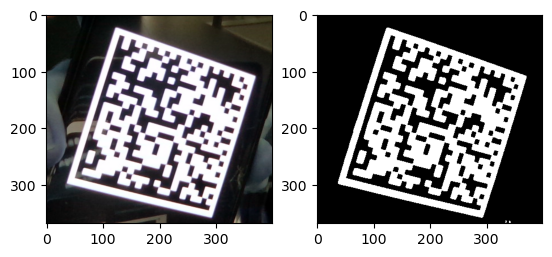

https://www.bluhmsysteme.com/bluhm-tv.html


In [3]:
# Getting cropped images
model = YOLO('../yolo/models/ultralytics_finetuned.pt')

# stat tracking
num_decodings = 0
num_valid_decodings = 0

imgs = []
titles = []

# Open camera
cam = cv2.VideoCapture(0)

# set camera focus
# focus = 255
# cam.set(cv2.CAP_PROP_FOCUS, focus)

# Loop through frames
decoded = False
while decoded == False:
    ret, frame = cam.read()

    # error handling
    if not ret:
        print("Failed to grab frame")
        break

    # Detect objects
    results = model(frame)
    boxes = results[0].boxes.xyxy.tolist()

    if boxes != None and len(boxes) > 0:
        # only look at box with highest confidence
        box = boxes[0]

        # crop with some padding (to not have too small of a crop)
        pad = 45
        crop_obj_pre_binarize = frame[max(0, int(box[1])-pad):max(0, int(box[3])+pad), max(0, int(box[0])-pad):max(0, int(box[2])+pad)]

        # binarize with otsu method
        crop_obj = binarize(crop_obj_pre_binarize)

        # show pre and post binarization crops
        clear_output(wait=True)
        plt.subplot(1, 2, 1)
        plt.imshow(crop_obj_pre_binarize)
        plt.subplot(1, 2, 2)
        plt.imshow(crop_obj, cmap='gray')
        plt.show()

        decodings = decode(crop_obj,
                           max_count=1,
                           threshold=50,
                           min_edge= 20,
                           max_edge=800,
                           # shape=DmtxSymbolSize.DmtxSymbol16x16,
                           timeout=1000,
                           )

        if decodings != None and len(decodings) > 0:
            num_decodings += 1

            for decoding in decodings:
                try:
                    decoded_string = decoding.data.decode(encoding='utf-8')
                    print(decoded_string)
                    decoded = True
                except:
                    pass

    cv2.imshow('Camera', frame)

    # Press 'q' to exit the loop
    if cv2.waitKey(1) == ord('q'):
        break

# Release the capture and writer objects
cam.release()
cv2.destroyAllWindows()

In [4]:
# from pylibdmtx.pylibdmtx import encode
# from PIL import Image

# for i in range(10):
#     dmc = encode('abcdefghijk' + str(i))
    
#     # dmc pixel bytes to image
#     img = Image.frombytes('RGB', (dmc.width, dmc.height), dmc.pixels).convert('L')
#     display(img)